In [1]:
!pip install -q pymupdf python-Levenshtein nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 71.9 MB/s eta 0:00:00


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Step-by-step PDF transcription

In [4]:
from transformers import NougatProcessor, VisionEncoderDecoderModel, infer_device
from datasets import load_dataset
import torch
from PIL import Image

🚨 `do_pad` is part of DefaultFastImageProcessorKwargs, but not documented. Make sure to add it to the docstring of the function in /usr/local/lib/python3.12/dist-packages/transformers/image_processing_utils_fast.py.
🚨 `pad_size` is part of DefaultFastImageProcessorKwargs, but not documented. Make sure to add it to the docstring of the function in /usr/local/lib/python3.12/dist-packages/transformers/image_processing_utils_fast.py.


In [5]:
processor = NougatProcessor.from_pretrained("facebook/nougat-base")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-base")

preprocessor_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

In [6]:
device = infer_device()
device

'cuda'

In [7]:
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )

In [8]:
from huggingface_hub import hf_hub_download

In [12]:
# prepare PDF image for the model

filepath = hf_hub_download(repo_id="ysharma/nougat", filename="input/nougat.pdf", repo_type="space")

In [15]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

In [21]:
def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    """
    Rasterize a PDF file to PNG images.

    Args:
        pdf (Path): The path to the PDF file.
        outpath (Optional[Path], optional): The output directory. If None, the PIL images will be returned instead. Defaults to None.
        dpi (int, optional): The output DPI. Defaults to 96.
        return_pil (bool, optional): Whether to return the PIL images instead of writing them to disk. Defaults to False.
        pages (Optional[List[int]], optional): The pages to rasterize. If None, all pages will be rasterized. Defaults to None.

    Returns:
        Optional[List[io.BytesIO]]: The PIL images if `return_pil` is True, otherwise None.
    """

    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images

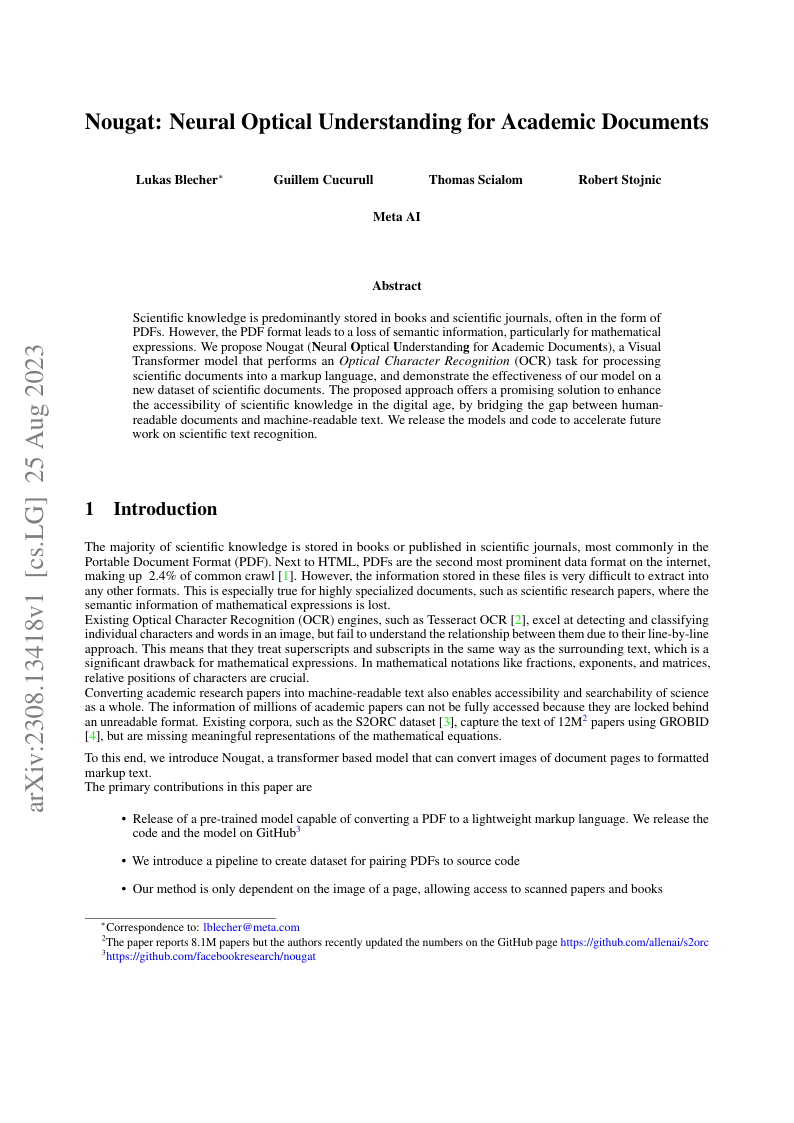

In [22]:
images = rasterize_paper(pdf=filepath, return_pil=True)
image = Image.open(images[0])
image

## Genererate Transcription

In [24]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 896, 672])


In [26]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

In [28]:
# autoregressively generate tokens, with custom stopping criteria (as defined by authors)

outputs = model.generate(
    pixel_values.to(device),
    min_length=1,
    max_length=405,
    bad_words_ids = [[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
    output_scores=True,
    stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
)

/tmp/ipython-input-4023200142.py:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  return torch.var(self.values, 1) / self.values.shape[1]


In [31]:
outputs.sequences.shape

torch.Size([1, 405])

## Post-processing

Finally we decode the generated IDs back to text and postprocess the generation.

In [35]:
generated_sequence = processor.batch_decode(
    outputs[0],
    skip_special_tokens=True,
)[0]

In [36]:
generated_sequence = processor.post_process_generation(
    generated_sequence,
    fix_markdown = False
)

In [37]:
print(generated_sequence)



# Nougat: Neural Optical Understanding for Academic Documents

 Lukas Blecher

Correspondence to: lblecher@meta.com

Guillem Cucurull

Thomas Scialom

Robert Stojnic

Meta AI

###### Abstract

Scientific knowledge is predominantly stored in books and scientific journals, often in the form of PDFs. However, the PDF format leads to a loss of semantic information, particularly for mathematical expressions. We propose Nougat (**N**eural **O**ptical **U**nderstanding for **A**cademic Documents), a Visual Transformer model that performs an _Optical Character Recognition_ (OCR) task for processing scientific documents into a markup language, and demonstrate the effectiveness of our model on a new dataset of scientific documents. The proposed approach offers a promising solution to enhance the accessibility of scientific knowledge in the digital age, by bridging the gap between human-readable documents and machine-readable text. We release the models and code to accelerate future work on sci

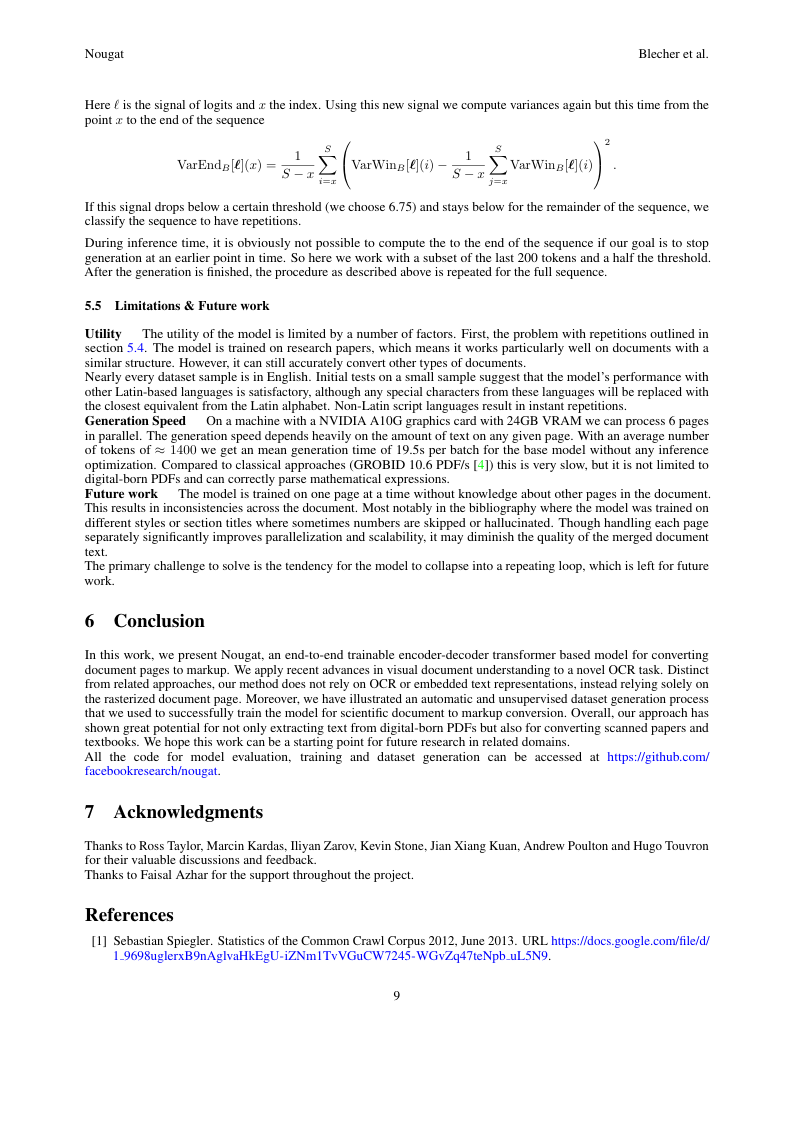

In [39]:
images = rasterize_paper(pdf=filepath, return_pil=True)
image = Image.open(images[8])
image

In [40]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 896, 672])


In [41]:
# autoregressively generate tokens, with custom stopping criteria (as defined by authors)

outputs = model.generate(
    pixel_values.to(device),
    min_length=1,
    max_length=405,
    bad_words_ids = [[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
    output_scores=True,
    stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
)

/tmp/ipython-input-4023200142.py:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  return torch.var(self.values, 1) / self.values.shape[1]


In [42]:
generated_sequence = processor.batch_decode(
    outputs[0],
    skip_special_tokens=True,
)[0]

generated_sequence = processor.post_process_generation(
    generated_sequence,
    fix_markdown = False
)

In [43]:
print(generated_sequence)

Here \(\ell\) is the signal of logits and \(x\) the index. Using this new signal we compute variances again but this time from the point \(x\) to the end of the sequence

\[\mathrm{VarEnd}_{B}[\bm{\ell}](x)=\frac{1}{S-x}\sum_{i=x}^{S}\left(\mathrm{Var Win}_{B}[\bm{\ell}](i)-\frac{1}{S-x}\sum_{j=x}^{S} \mathrm{VarWin}_{B}[\bm{\ell}](i)\right)^{2}.\]

If this signal drops below a certain threshold (we choose 6.75) and stays below for the remainder of the sequence, we classify the sequence to have repetitions.

During inference time, it is obviously not possible to compute the to the end of the sequence if our goal is to stop generation at an earlier point in time. So here we work with a subset of the last 200 tokens and a half the threshold. After the generation is finished, the procedure as described above is repeated for the full sequence.

### Limitations & Future work

**Utility** The utility of the model is limited by a number of factors. First, the problem with repetitions outlined

In [69]:
def transcribe_image(image, processor, model, device):
    """
    Transcribes a single image using the Nougat model.

    Args:
        image (PIL.Image.Image): The input image.
        processor: The Nougat processor.
        model: The Nougat model.
        device: The device to run the model on.

    Returns:
        str: The transcribed text.
    """
    pixel_values = processor(image, return_tensors="pt").pixel_values
    outputs = model.generate(
        pixel_values.to(device),
        min_length=1,
        max_length=4500,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_scores=True,
        stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
    )
    generated_sequence = processor.batch_decode(
        outputs[0],
        skip_special_tokens=True,
    )[0]
    generated_sequence = processor.post_process_generation(
        generated_sequence,
        fix_markdown=False
    )
    return generated_sequence


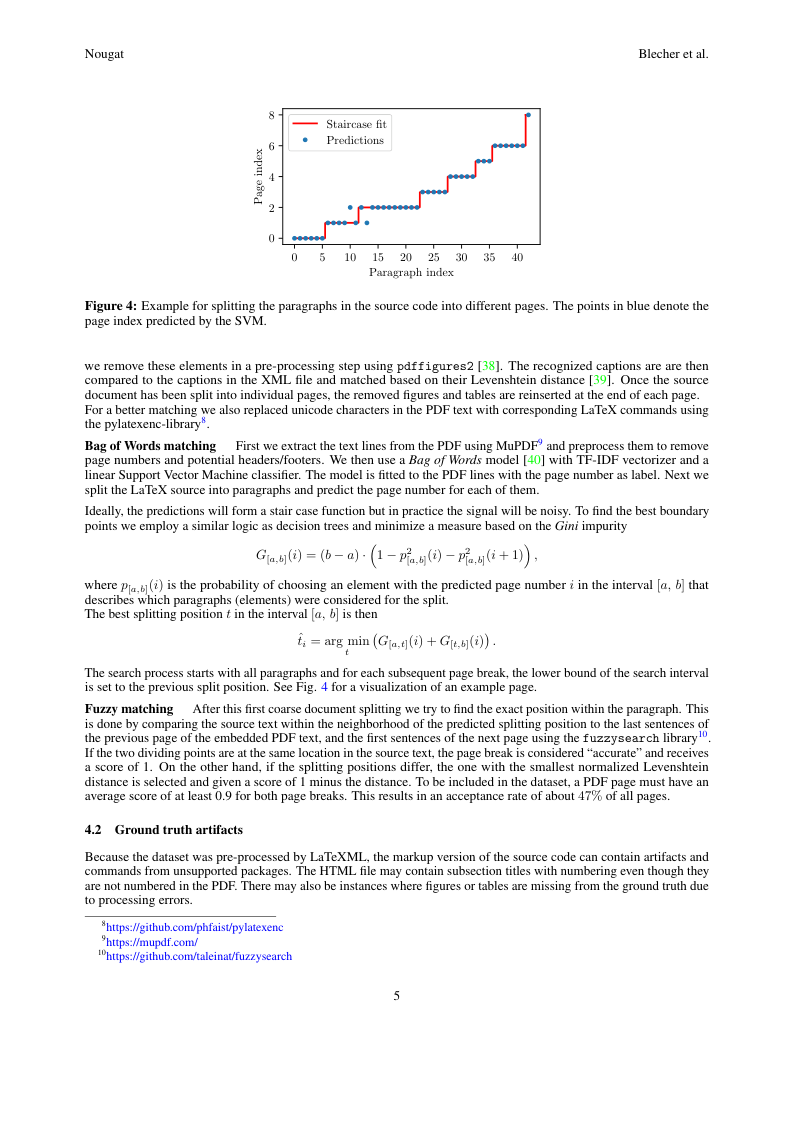

In [70]:
images = rasterize_paper(pdf=filepath, return_pil=True)
image = Image.open(images[4])
image

In [71]:
print(transcribe_image(image, processor, model, device))

/tmp/ipython-input-4023200142.py:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  return torch.var(self.values, 1) / self.values.shape[1]


we remove these elements in a pre-processing step using pdffigures2[38]. The recognized captions are are then compared to the captions in the XML file and matched based on their Levenshtein distance [39]. Once the source document has been split into individual pages, the removed figures and tables are reinserted at the end of each page.

For a better matching we also replaced unicode characters in the PDF text with corresponding LaTeX commands using the pylatexenc-library8.

Footnote 8: https://github.com/phfaist/pylatexenc

**Bag of Words matching**  First we extract the text lines from the PDF using MuPDF9 and preprocess them to remove page numbers and potential headers/footers. We then use a _Bag of Words_ model [40] with TF-IDF vectorizer and a linear Support Vector Machine classifier. The model is fitted to the PDF lines with the page number as label. Next we split the LaTeX source into paragraphs and predict the page number for each of them.

Footnote 9: https://mupdf.com/

Ideal

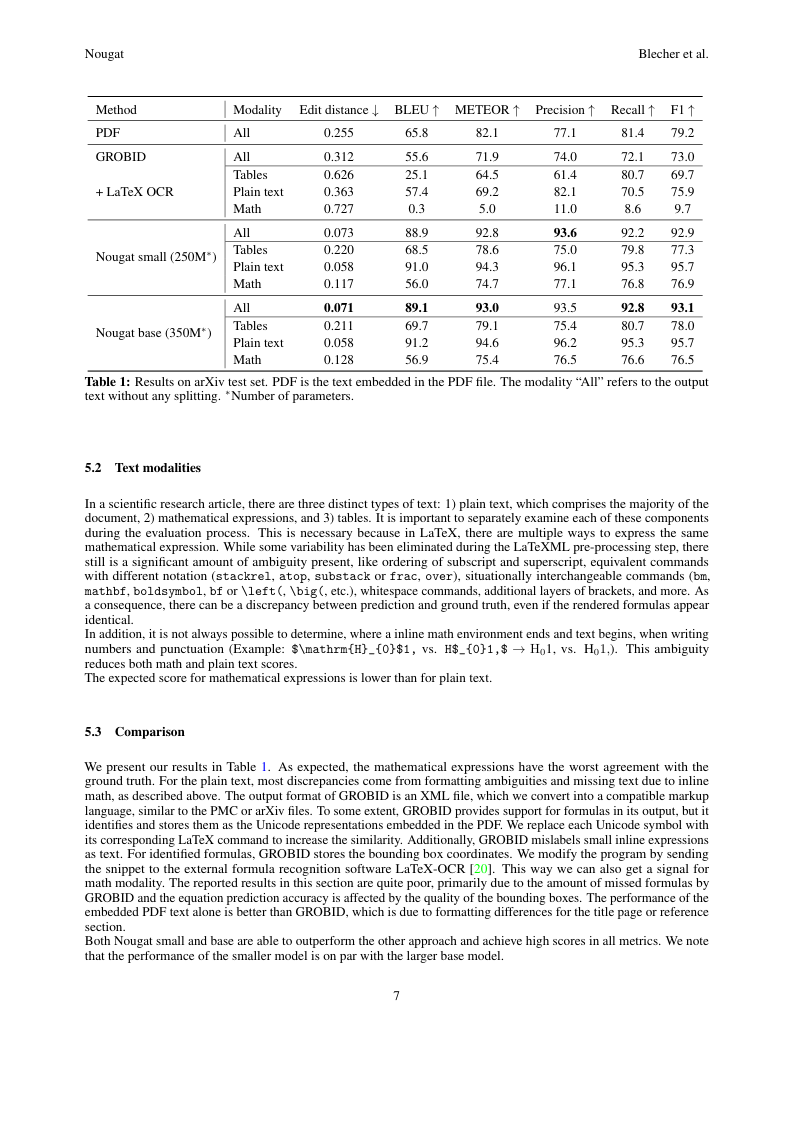

In [72]:
images = rasterize_paper(pdf=filepath, return_pil=True)
image = Image.open(images[6])
image

In [73]:
print(transcribe_image(image, processor, model, device))

/tmp/ipython-input-4023200142.py:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  return torch.var(self.values, 1) / self.values.shape[1]




### Text modalities

In a scientific research article, there are three distinct types of text: 1) plain text, which comprises the majority of the document, 2) mathematical expressions, and 3) tables. It is important to separately examine each of these components during the evaluation process. This is necessary because in LaTeX, there are multiple ways to express the same mathematical expression. While some variability has been eliminated during the LaTeXML pre-processing step, there still is a significant amount of ambiguity present, like ordering of subscript and superscript, equivalent commands with different notation (stackrel, atop, substack or frac, over), situationally interchangeable commands (bm, mathbf, boldsymbol, bf or left(, big(, etc.), whitespace commands, additional layers of brackets, and more. As a consequence, there can be a discrepancy between prediction and ground truth, even if the rendered formulas appear identical.

In addition, it is not always possible to det

In [74]:
!pip install -q gradio